In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import rasterio
from pathlib import Path
from tqdm import tqdm
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import numpy as np
import geopandas as gpd
from rasterio.plot import show
from rio_tools import get_cropped_profile
import yaml
from datetime import datetime
from mpl_toolkits.axes_grid1 import make_axes_locatable


In [31]:
EVENT_NAME = 'chile_fire_2024'
TRACK_IDX = 0

In [32]:
DIST_EVENT_REPO = Path('../../../dist-s1-events')
DIST_EVENT_REPO.exists()

True

In [33]:
DATA_DIR = DIST_EVENT_REPO / 'out'
DATA_DIR.exists()

True

In [34]:
EVENT_DIR = DATA_DIR / EVENT_NAME
EVENT_DIR.exists()

True

In [35]:
VAL_DATA_VECTOR_DIR = DIST_EVENT_REPO / 'external_validation_data_db/'
VAL_DATA_VECTOR_DIR, VAL_DATA_VECTOR_DIR.exists()

(PosixPath('../../../dist-s1-events/external_validation_data_db'), True)

In [36]:
VAL_AOI_VECTOR_DIR = DIST_EVENT_REPO / 'external_validation_data_extents_db/'
VAL_AOI_VECTOR_DIR, VAL_AOI_VECTOR_DIR.exists()

(PosixPath('../../../dist-s1-events/external_validation_data_extents_db'),
 True)

In [37]:
EVENT_YAML_DIR = DIST_EVENT_REPO / 'events'
EVENT_YAML_DIR, EVENT_YAML_DIR.exists()

(PosixPath('../../../dist-s1-events/events'), True)

In [38]:
yaml_file = EVENT_YAML_DIR / f'{EVENT_NAME}.yml'
with open(yaml_file) as f:
    event_dict = yaml.safe_load(f)["event"]
event_dict

{'event_name': 'chile_fire_2024',
 'bounds': [-71.53071089, -33.20143816, -71.2964628, -32.98270579],
 'event_date': '2024-02-04',
 'pre_event_window_days': 180,
 'post_event_window_days': 100,
 'rtc_track_numbers': [18, 156],
 'mgrs_tiles': ['19HBD'],
 'source_id': 'EMSR715 AOI1',
 'dist_hls_confirmed_change_min_days': 30,
 'links': ['https://earthobservatory.nasa.gov/images/152411/fires-rage-in-central-chile',
  'https://en.wikipedia.org/wiki/2024_Chile_wildfires']}

# RTC Data

In [39]:
rtc_dir = EVENT_DIR / 'rtc_ts_merged'
rtc_dir.exists()

True

In [40]:
tracks = sorted([int(d.stem.replace('track', '')) for d in rtc_dir.glob('*/')])
tracks

[18, 156]

In [41]:
TRACK = tracks[TRACK_IDX]
TRACK

18

In [42]:
ts_dir = rtc_dir / f'track{tracks[TRACK_IDX]}'
ts_dir

PosixPath('../../../dist-s1-events/out/chile_fire_2024/rtc_ts_merged/track18')

# Dates

In [43]:
rtc_acq_dts = sorted([datetime.strptime(p.stem.split('_')[1], '%Y-%m-%d') for p in ts_dir.glob('*VV.tif')])
rtc_acq_dts[:3]

[datetime.datetime(2023, 11, 1, 0, 0),
 datetime.datetime(2023, 11, 13, 0, 0),
 datetime.datetime(2023, 11, 25, 0, 0)]

In [44]:
event_date = datetime.strptime(event_dict['event_date'], '%Y-%m-%d')
event_date

datetime.datetime(2024, 2, 4, 0, 0)

# Val Data

In [45]:
VAL_DIR = EVENT_DIR / 'validation_data'

AOI_DATA_PATH = [p for p in VAL_DIR.glob('*.tif') if 'extent_datamask' in p.stem][0]
VAL_DATA_PATH = [p for p in VAL_DIR.glob('*.tif') if 'extent_datamask' not in p.stem][0]

In [46]:
with rasterio.open(AOI_DATA_PATH) as ds:
    X_extent = ds.read(1)
    crs_utm = ds.crs
    trans_utm = ds.transform

In [47]:
with rasterio.open(VAL_DATA_PATH) as ds:
    X_val = ds.read(1)

<Axes: >

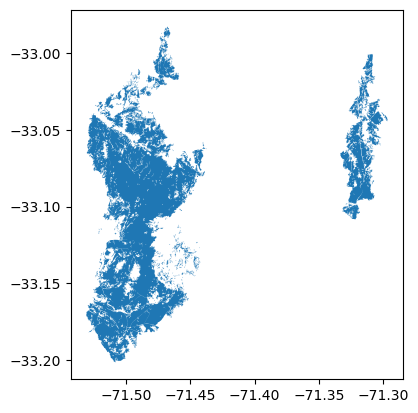

In [48]:
parquet_file = VAL_DATA_VECTOR_DIR / f'{EVENT_NAME}.parquet'
geojson_file = VAL_DATA_VECTOR_DIR / f'{EVENT_NAME}.geojson'

df_val = gpd.read_file(geojson_file) if geojson_file.exists() else gpd.read_parquet(parquet_file)
df_val.plot()

<Axes: >

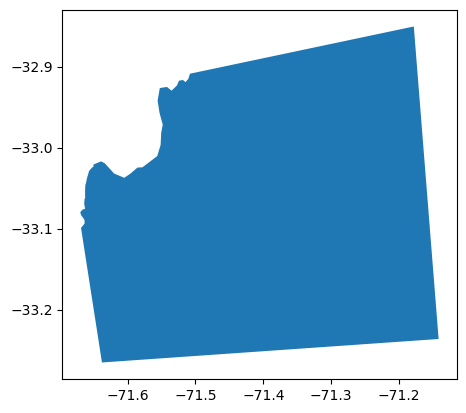

In [49]:
aoi_file = VAL_AOI_VECTOR_DIR / f'{EVENT_NAME}.geojson'

df_val_aoi = gpd.read_file(aoi_file)
df_val_aoi.plot()

In [50]:
df_val_aoi_utm = df_val_aoi.to_crs(crs_utm)
df_val_utm = df_val.to_crs(crs_utm)

# SLICE DICT

In [63]:
slice_dict = {'papau_new_guinea_landslide_2024': (np.s_[3150:3200],
                                                  np.s_[2050: 2100]),
              'chiapas_fire_2024': (np.s_[1500:2500], np.s_[750:2000]),
              'chile_fire_2024': (np.s_[1700:2600], np.s_[2050: 2900]),
              'southwest_france_flood_2023': (np.s_[150:1600], 
                                              np.s_[1600:3700]),
              'yajiang_fire_2024': (np.s_[1770:2500], np.s_[2900:4200]),
              'afghanistan_flood_2024': (np.s_[2150:3400], np.s_[100:1500]),
              'bioko_fire_2024': (np.s_[50:250], np.s_[2315:2515]),
              'park_fire_2024': (np.s_[750: 3500], np.s_[2500:4500]),
              'smokehouse_creek_fire_2024': (np.s_[250:2250], np.s_[2250:7500]),
              'attica_fire_2024': (np.s_[2_000:3_000], np.s_[1600:2100])
             }

sy, sx = slice_dict[EVENT_NAME]

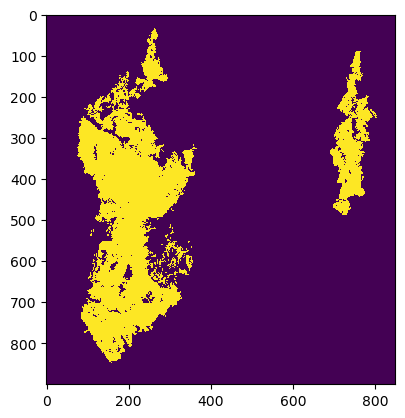

In [64]:
Z = X_val[sy, sx]

plt.imshow(Z, interpolation='none')

In [65]:
vh_paths = sorted(list(ts_dir.glob('*VH.tif')))
vv_paths = sorted(list(ts_dir.glob('*VV.tif')))

vh_paths[:3], vv_paths[:3]

([PosixPath('../../../dist-s1-events/out/chile_fire_2024/rtc_ts_merged/track18/merged_2023-11-01_track18_VH.tif'),
  PosixPath('../../../dist-s1-events/out/chile_fire_2024/rtc_ts_merged/track18/merged_2023-11-13_track18_VH.tif'),
  PosixPath('../../../dist-s1-events/out/chile_fire_2024/rtc_ts_merged/track18/merged_2023-11-25_track18_VH.tif')],
 [PosixPath('../../../dist-s1-events/out/chile_fire_2024/rtc_ts_merged/track18/merged_2023-11-01_track18_VV.tif'),
  PosixPath('../../../dist-s1-events/out/chile_fire_2024/rtc_ts_merged/track18/merged_2023-11-13_track18_VV.tif'),
  PosixPath('../../../dist-s1-events/out/chile_fire_2024/rtc_ts_merged/track18/merged_2023-11-25_track18_VV.tif')])

In [66]:
def open_one(path: Path):
    with rasterio.open(path) as ds:
        X = ds.read(1)
        p = ds.profile
    return X, p

In [67]:
vhs, ps = zip(*list(map(open_one, tqdm(vh_paths))))
vvs, ps = zip(*list(map(open_one, tqdm(vv_paths))))

100%|██| 13/13 [00:01<00:00,  7.42it/s]


# Plot 1 

In [68]:
# import  matplotlib.pyplot as plt

# X = [ (2,1,1), (2,3,4), (2,3,5), (2,3,6) ]
# for nrows, ncols, plot_number in X:
#     plt.subplot(nrows, ncols, plot_number)

In [79]:
show_delineation = show_aoi = False
if EVENT_NAME in ['papau_new_guinea_landslide_2024', 
                  'chiapas_fire_2024',
                  'yajiang_fire_2024',
                  'bioko_fire_2024',
                  'park_fire_2024',
                  'attica_fire_2024',
                  'smokehouse_creek_fire_2024',
                  #'chile_fire_2024'
                 ]:
    show_delineation = True
if EVENT_NAME in ['chile_fire_2024', 
                  'southwest_france_flood_2023',
                  'afghanistan_flood_2024']:
    show_aoi = True

Text(2024-02-04 00:00:00, 0.05, ' Event: 2024-02-04')

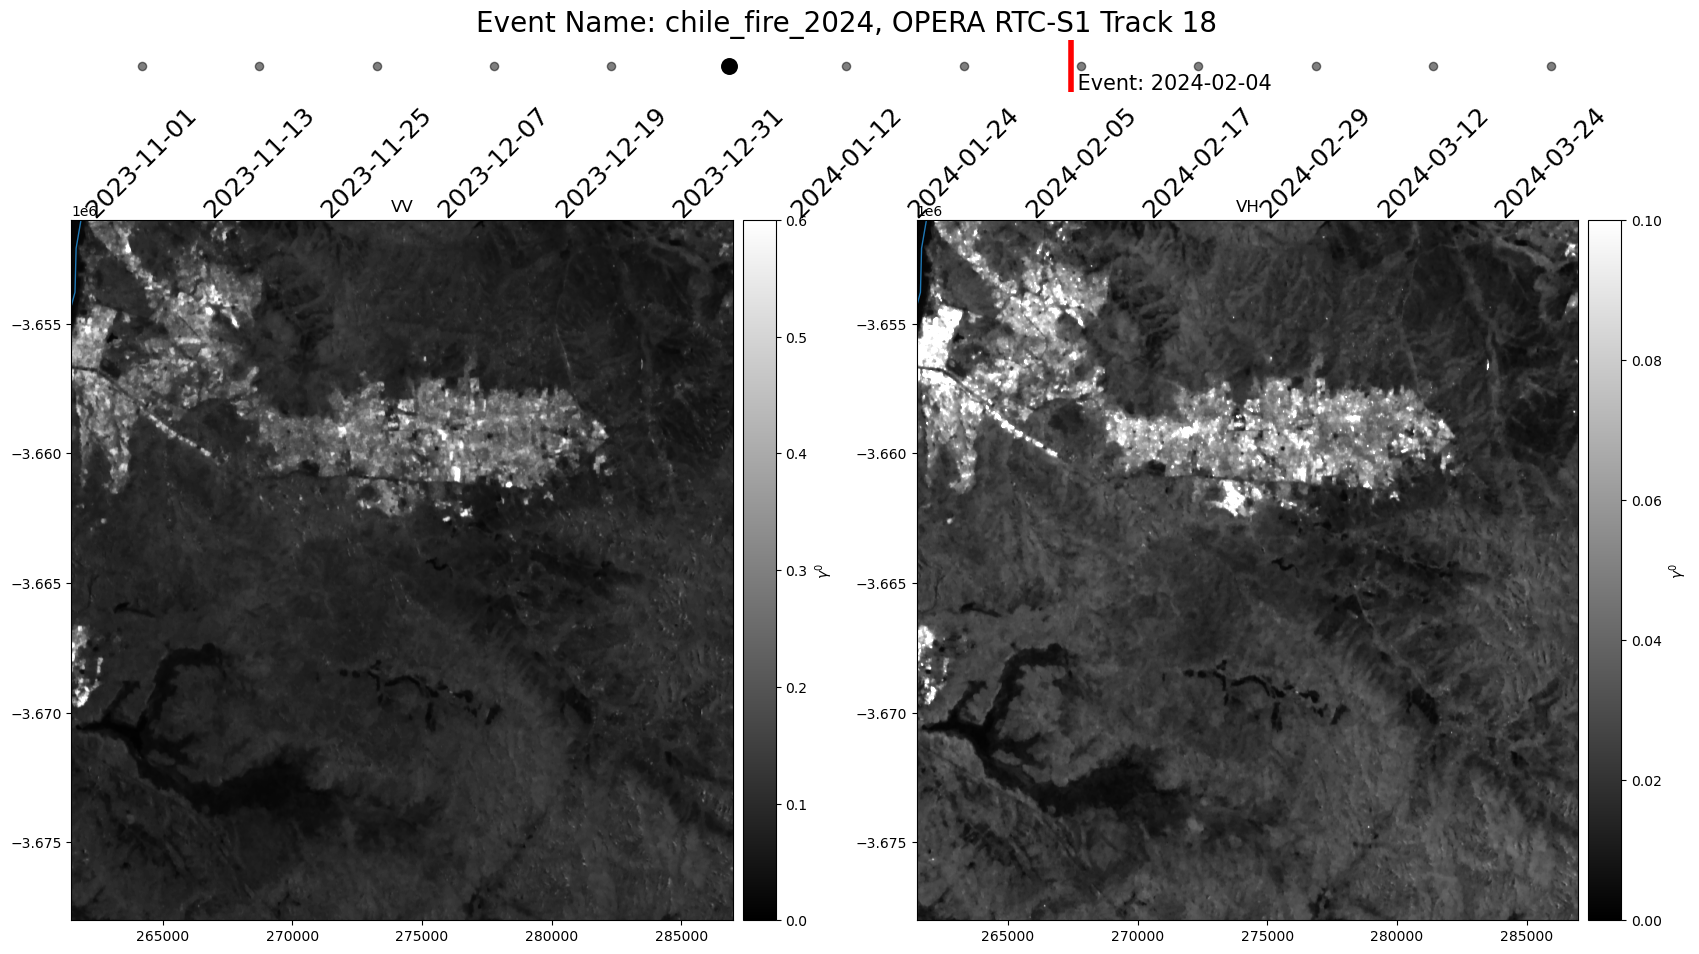

In [80]:
acq_idx = 5
##########################
##### Copy and Paste here
##########################
fig = plt.figure(figsize=(20, 12))

gs = fig.add_gridspec(2,2, height_ratios=[1, 15])
ax0 = fig.add_subplot(gs[1, 0])
ax1 = fig.add_subplot(gs[1, 1])
ax_time = fig.add_subplot(gs[0, :])

p_c = get_cropped_profile(ps[0], sx, sy)

p_data_0 = show(vvs[acq_idx][sy, sx], cmap='binary_r', transform=p_c['transform'], ax=ax0, vmin=0, vmax=.6)
im_0 = p_data_0.get_images()[0]
img_xlims = ax0.get_xlim()
img_ylims = ax0.get_ylim()

ax0.set_title('VV')
ax0.set_ylim(*img_ylims)
ax0.set_xlim(*img_xlims)

p_data_1 = show(vhs[acq_idx][sy, sx], cmap='binary_r', transform=p_c['transform'], ax=ax1, vmin=0, vmax=.1)
im_1 = p_data_1.get_images()[0]
ax1.set_title('VH')

if show_delineation:
    df_val_utm.boundary.plot(ax=ax0, lw=.5, edgecolor='yellow')
    df_val_utm.boundary.plot(ax=ax1, lw=.5, edgecolor='yellow')
if show_aoi:
    df_val_aoi_utm.boundary.plot(ax=ax0, lw=1)
    df_val_aoi_utm.boundary.plot(ax=ax1, lw=1)


ax1.set_ylim(*img_ylims)
ax1.set_xlim(*img_xlims)

divider0 = make_axes_locatable(ax0)
cax0 = divider0.append_axes("right", size="5%", pad=0.1)
fig.colorbar(im_0, cax=cax0)
cax0.set_ylabel('$\\gamma^0$')

divider1 = make_axes_locatable(ax1)
cax1 = divider1.append_axes("right", size="5%", pad=0.1)
fig.colorbar(im_1, cax=cax1)
cax1.set_ylabel('$\\gamma^0$')

##################
# Timeline
##################

ax_time.scatter(rtc_acq_dts, [.5] * len(rtc_acq_dts),
    c='black',
    marker='o',
    linewidth=1,
    s=35,
    alpha=.5)
ax_time.scatter([rtc_acq_dts[acq_idx]], .5, s=125, marker='o', linewidth=1, color='black')

ax_time.set_xticks(rtc_acq_dts)
acq_dts_str = [d.strftime('%Y-%m-%d') for d in rtc_acq_dts]
ax_time.set_xticklabels(acq_dts_str, rotation=45, fontsize=18)
ax_time.xaxis.set_ticks_position('none') 

ax_time.spines['top'].set_visible(False)
ax_time.spines['left'].set_visible(False)
ax_time.spines['right'].set_visible(False)
ax_time.spines['bottom'].set_visible(False)

ax_time.set_yticks([])
ax_time.vlines(event_date, 0, 1, color='red', lw=4)
ax_time.set_ylim(0, 1)
ax_time.set_title(f'Event Name: {EVENT_NAME}, OPERA RTC-S1 Track {TRACK}', fontsize=20)

ax_time.annotate(f' Event: {event_date.strftime('%Y-%m-%d')}', (event_date, .05), fontsize=15)
##################


# Animation With Pngs

In [81]:
png_dir = Path('out_pngs')
gif_dir = Path('out_gifs')

event_png_dir = png_dir / f'{EVENT_NAME}__track{TRACK}'
event_png_dir.mkdir(exist_ok=True, parents=True)

gif_dir.mkdir(exist_ok=True, parents=True)

In [82]:
len(rtc_acq_dts)

13

In [ ]:
for acq_idx in tqdm(range(len(rtc_acq_dts))):

    fig = plt.figure(figsize=(20, 12))
    
    gs = fig.add_gridspec(2,2, height_ratios=[1, 15])
    ax0 = fig.add_subplot(gs[1, 0])
    ax1 = fig.add_subplot(gs[1, 1])
    ax_time = fig.add_subplot(gs[0, :])
    
    p_c = get_cropped_profile(ps[0], sx, sy)
    
    p_data_0 = show(vvs[acq_idx][sy, sx], cmap='binary_r', transform=p_c['transform'], ax=ax0, vmin=0, vmax=.6)
    im_0 = p_data_0.get_images()[0]
    img_xlims = ax0.get_xlim()
    img_ylims = ax0.get_ylim()
    
    ax0.set_title('VV')
    ax0.set_ylim(*img_ylims)
    ax0.set_xlim(*img_xlims)
    
    p_data_1 = show(vhs[acq_idx][sy, sx], cmap='binary_r', transform=p_c['transform'], ax=ax1, vmin=0, vmax=.1)
    im_1 = p_data_1.get_images()[0]
    ax1.set_title('VH')
    
    if show_delineation:
        df_val_utm.boundary.plot(ax=ax0, lw=.5, edgecolor='yellow')
        df_val_utm.boundary.plot(ax=ax1, lw=.5, edgecolor='yellow')
    if show_aoi:
        df_val_aoi_utm.boundary.plot(ax=ax0, lw=1)
        df_val_aoi_utm.boundary.plot(ax=ax1, lw=1)
    
    
    ax1.set_ylim(*img_ylims)
    ax1.set_xlim(*img_xlims)
    
    divider0 = make_axes_locatable(ax0)
    cax0 = divider0.append_axes("right", size="5%", pad=0.1)
    fig.colorbar(im_0, cax=cax0)
    cax0.set_ylabel('$\\gamma^0$')
    
    divider1 = make_axes_locatable(ax1)
    cax1 = divider1.append_axes("right", size="5%", pad=0.1)
    fig.colorbar(im_1, cax=cax1)
    cax1.set_ylabel('$\\gamma^0$')
    
    ##################
    # Timeline
    ##################
    
    ax_time.scatter(rtc_acq_dts, [.5] * len(rtc_acq_dts),
        c='black',
        marker='o',
        linewidth=1,
        s=35,
        alpha=.5)
    ax_time.scatter([rtc_acq_dts[acq_idx]], .5, s=125, marker='o', linewidth=1, color='black')
    
    ax_time.set_xticks(rtc_acq_dts)
    acq_dts_str = [d.strftime('%Y-%m-%d') for d in rtc_acq_dts]
    ax_time.set_xticklabels(acq_dts_str, rotation=45, fontsize=18)
    ax_time.xaxis.set_ticks_position('none') 
    
    ax_time.spines['top'].set_visible(False)
    ax_time.spines['left'].set_visible(False)
    ax_time.spines['right'].set_visible(False)
    ax_time.spines['bottom'].set_visible(False)
    
    ax_time.set_yticks([])
    ax_time.vlines(event_date, 0, 1, color='red', lw=4)
    ax_time.set_ylim(0, 1)
    ax_time.set_title(f'Event Name: {EVENT_NAME}, OPERA RTC-S1 Track {TRACK}', fontsize=20)
    
    ax_time.annotate(f' Event: {event_date.strftime('%Y-%m-%d')}', (event_date, .05), fontsize=15)
    ##################
    plt.tight_layout()
    plt.savefig(event_png_dir / f'{acq_dts_str[acq_idx]}.png')
    plt.close()

 23%|▋  | 3/13 [00:02<00:06,  1.48it/s]

In [ ]:
source_images = sorted(list(event_png_dir.glob('*.png')))
len(source_images)

In [ ]:
from PIL import Image

def create_gif(input_pngs, output_file, duration=1_000, loop=0):

    images = []
    for png_file in input_pngs:
        img = Image.open(png_file)
        # This improves quality significantly
        img = img.convert('RGB').convert('P', palette=Image.ADAPTIVE, colors=255)
        images.append(img)

    # Save as GIF
    images[0].save(output_file,
                   save_all=True,
                   append_images=images[1:],
                   duration=duration,
                   loop=loop,
                   optimize=False,
                   quality=100)  # High quality setting

    return output_file

In [ ]:
out_path = gif_dir / f'{EVENT_NAME}_track{TRACK}.gif'

create_gif(source_images, out_path)